In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats
# from deside.utility import cancer_types, check_dir, read_marker_gene, calculate_rmse, set_fig_style
from deside.decon_cf import DeSide
from deside.utility.read_file import read_gene_set
from deside.utility.compare import read_and_merge_result, cal_gene_signature_score
from deside.utility import (ExpObj, set_fig_style, sorted_cell_types, read_marker_gene,
                            get_corr, check_dir, cancer_types, get_ccc, get_corr_spearman,
                            read_cancer_purity, calculate_rmse, print_df, calculate_mae)
# sns.set(font_scale=2)
# sns.set_style("white")
from sklearn.metrics import median_absolute_error
set_fig_style(font_family='Arial', font_size=8)

2024-06-27 11:20:11.994679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
fig_dir = './fig4/'
dataset_dir = '../datasets/'
result_dir = '../results/whole_workflow_20231110_12ds_subtypes/DeSide_03_new_ds_subtypes_all_range/'

---
## 3 SC test sets
- from  https://science.bostongene.com/kassandra/downloads

In [3]:
algo2cell_type_name_mapping = {
        'CIBERSORTx_HNSCC': {'B cell': 'B Cells', 'T cells CD4': 'CD4 T', 'T cells CD8': 'CD8 T', 'Dendritic': 'DC',
                            'Malignant': 'Cancer Cells', 'Endothelial': 'Endothelial Cells',
                            'Fibroblast': 'Fibroblasts', 'Macrophage': 'Macrophages', 'Mast': 'Mast Cells',
                            },
        'EPIC_TRef': {'B.cells': 'B Cells', 'CD4.T': 'CD4 T', 'CD8.T': 'CD8 T',
                      'otherCells': 'Cancer Cells', 'Endothelial.Cells': 'Endothelial Cells',
                      'Fibroblasts': 'Fibroblasts',  'NK': 'NK', 'Macrophages': 'Macrophages',
                      },
        'Scaden_ascites': {'CD4Tcells': 'CD4 T', 'CD8Tcells': 'CD8 T', 'Carcinoma': 'Cancer Cells',
                           'DC': 'DC', 'Fibroblast': 'Fibroblasts', 'NK': 'NK',
                          },
        'Kassandra_self': {'B_cells': 'B Cells', 'CD4_T_cells': 'CD4 T', 'CD8_T_cells': 'CD8 T',
                           'Endothelium': 'Endothelial Cells', 'Fibroblasts': 'Fibroblasts', 'Macrophages': 'Macrophages',
                           'NK_cells': 'NK', 'Neutrophils': 'Neutrophils', 'Other': 'Cancer Cells'},
}

### Merged predicted cell prop.

In [4]:
ind_ds_dir = '../datasets/Independent_Test_Set/to_xiongxin/'
cell_prop_pred = pd.read_csv(os.path.join(ind_ds_dir, 'validation_datasets_predicted_by_algorithms/predicted_by_algorithms/cell_propotion_with_four_datasets.csv'), index_col=0)
cell_prop_pred.loc[cell_prop_pred['cell_proportion'] < 0, 'cell_proportion'] = 0
cell_prop_pred.loc[cell_prop_pred['cell_proportion'] > 100, 'cell_proportion'] = 100
# remove CIBERSORT and fardeep_relative since the sum != 100
cell_prop_pred = cell_prop_pred.loc[cell_prop_pred['algo'].isin(['DeSide', 'EPIC_TRef', 'Kassandra', 'HNSC_matrix_with_BC_CIBERSORTX']), :].copy()
cell_prop_pred.head(2)

,sample_id,algo,cell_type,cell_proportion,datasets
3050,SRR8030893,DeSide,Plasma B cells,0.0,GSE121127
3051,SRR8030893,DeSide,Non-plasma B cells,0.0,GSE121127


In [5]:
cell_prop_pred['algo'].unique()

array(['DeSide', 'EPIC_TRef', 'HNSC_matrix_with_BC_CIBERSORTX',
       'Kassandra'], dtype=object)

In [6]:
cell_prop_pred['datasets'].unique()

array(['GSE121127', 'SC_glioblastoma', 'SC_HNSCC', 'SC_ovarian_cancer'],
      dtype=object)

#### Predicted cell prop. by Scaden
- The provided results for Scaden is not complete by above downloaded dataset, so we calculated for these 3 datasets using Scaden (ascites) locally 

In [7]:
pred_dir = os.path.join(ind_ds_dir, 'validation_datasets_expression')
ds2file_name = {'SC_glioblastoma': 'scaden_ascites_pred_cell_prop_sc_glioblastoma.txt', 'SC_HNSCC': 'scaden_ascites_pred_cell_prop_sc_hnscc.txt', 
                'SC_ovarian_cancer': 'scaden_ascites_pred_cell_prop_sc_overian.txt'}
cell_prop_pred_scaden = []
for ds, file in ds2file_name.items():
    current_result = pd.read_csv(os.path.join(pred_dir, file), index_col=0, sep='\t')
    current_result['datasets'] = ds
    print(ds, current_result.shape)
    cell_prop_pred_scaden.append(current_result)
cell_prop_pred_scaden_df = pd.concat(cell_prop_pred_scaden)
cell_prop_pred_scaden_df['algo'] = 'Scaden_ascites'
name_mapping = algo2cell_type_name_mapping['Scaden_ascites']
name_mapping['index'] = 'sample_id'
cell_prop_pred_scaden_df.reset_index(inplace=True)
cell_prop_pred_scaden_df.rename(columns=name_mapping, inplace=True)
cell_prop_pred_scaden_df['T Cells'] = cell_prop_pred_scaden_df.loc[:, ['CD4 T', 'CD8 T']].sum(axis=1)
print(cell_prop_pred_scaden_df.head(2))
cell_prop_pred_scaden_df['Lymphocytes'] = cell_prop_pred_scaden_df.loc[:, ['T Cells', 'NK']].sum(axis=1)
cell_prop_pred_scaden_df['Macrophages'] = cell_prop_pred_scaden_df['Monocytes'].copy()
print_df(cell_prop_pred_scaden_df)

SC_glioblastoma (28, 8)
SC_HNSCC (22, 8)
SC_ovarian_cancer (8, 8)
  sample_id     CD8 T  Monocytes  Cancer Cells        NK        DC     CD4 T  \
0    BT1160  0.064242   0.028067      0.343179  0.091911  0.094807  0.228585   
1    BT1187  0.016600   0.872636      0.011351  0.027116  0.027774  0.037215   

   Fibroblasts         datasets            algo   T Cells  
0     0.149208  SC_glioblastoma  Scaden_ascites  0.292827  
1     0.007307  SC_glioblastoma  Scaden_ascites  0.053816  
  >>  <<  
(58, 13)
  sample_id     CD8 T  Monocytes  Cancer Cells        NK        DC     CD4 T  \
0    BT1160  0.064242   0.028067      0.343179  0.091911  0.094807  0.228585   
1    BT1187  0.016600   0.872636      0.011351  0.027116  0.027774  0.037215   

   Fibroblasts         datasets            algo   T Cells  Lymphocytes  \
0     0.149208  SC_glioblastoma  Scaden_ascites  0.292827     0.384738   
1     0.007307  SC_glioblastoma  Scaden_ascites  0.053816     0.080931   

   Macrophages  
0     0.0280

In [8]:
cell_prop_pred_scaden_df.head(2)

,sample_id,CD8 T,Monocytes,Cancer Cells,NK,DC,CD4 T,Fibroblasts,datasets,algo,T Cells,Lymphocytes,Macrophages
0,BT1160,0.064242,0.028067,0.343179,0.091911,0.094807,0.228585,0.149208,SC_glioblastoma,Scaden_ascites,0.292827,0.384738,0.028067
1,BT1187,0.016600,0.872636,0.011351,0.027116,0.027774,0.037215,0.007307,SC_glioblastoma,Scaden_ascites,0.053816,0.080931,0.872636


In [9]:
cell_types = [
    'CD8 T',
    'Monocytes',
    'Cancer Cells',
    'NK',
    'DC',
    'CD4 T',
    'Fibroblasts',
    'T Cells',
    'Lymphocytes',
    'Macrophages',
]
cell_prop_pred_scaden_list = []
for ct in cell_types:
    current_part = cell_prop_pred_scaden_df.loc[:, ['sample_id', 'datasets', 'algo']].copy()
    current_part['cell_type'] = ct
    current_part['cell_proportion'] = cell_prop_pred_scaden_df.loc[:, ct].copy()
    cell_prop_pred_scaden_list.append(current_part)
cell_prop_pred_scaden_df_long = pd.concat(cell_prop_pred_scaden_list)
print_df(cell_prop_pred_scaden_df_long)

  >>  <<  
(580, 5)
  sample_id         datasets            algo cell_type  cell_proportion
0    BT1160  SC_glioblastoma  Scaden_ascites     CD8 T         0.064242
1    BT1187  SC_glioblastoma  Scaden_ascites     CD8 T         0.016600


In [10]:
cell_prop_pred_new = pd.concat([cell_prop_pred, cell_prop_pred_scaden_df_long])
print_df(cell_prop_pred_new)

  >>  <<  
(6860, 5)
       sample_id    algo           cell_type  cell_proportion   datasets
3050  SRR8030893  DeSide      Plasma B cells              0.0  GSE121127
3051  SRR8030893  DeSide  Non-plasma B cells              0.0  GSE121127


In [11]:
cell_prop_pred_new['algo'].unique()

array(['DeSide', 'EPIC_TRef', 'HNSC_matrix_with_BC_CIBERSORTX',
       'Kassandra', 'Scaden_ascites'], dtype=object)

### Dataset SC_glioblastoma

In [12]:
ds2 = 'SC_glioblastoma'
cell_prop_true_gbm = pd.read_csv(f'{ind_ds_dir}/validation_datasets_cell_values/cell_values/{ds2}.csv', index_col=0).T
print(cell_prop_true_gbm.shape)
cell_prop_true_gbm.head(2)

(28, 3)


,Macrophages,Cancer Cells,T Cells
BT1160,0.000000,100.000000,0.000000
BT1187,89.954338,3.652968,6.392694


In [13]:
cell_prop_true_gbm = cell_prop_true_gbm / 100

### Dataset SC_HNSCC

In [14]:
ds3 = 'SC_HNSCC'
cell_prop_true_hnscc = pd.read_csv(f'{ind_ds_dir}/validation_datasets_cell_values/cell_values/{ds3}.csv', index_col=0).T
print(cell_prop_true_hnscc.shape)
cell_prop_true_hnscc.head(2)

(22, 14)


,CD4 T,DC,Endothelial Cells,Fibroblasts,Macrophages,Mast_cells,Myofibroblasts,Non-plasma B cells,Plasma B cells,Cancer Cells,CD8 T,T Cells,B Cells,Lymphocytes
lymph_node_20,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.292398,0.000000,0.000000,99.707602,0.000000,0.000000,0.000000,0.000000
lymph_node_25,22.068966,0.689655,0.0,3.103448,0.689655,1.034483,33.103448,0.344828,8.965517,25.862069,4.137931,26.206897,9.310345,35.517241


In [15]:
cell_prop_true_hnscc = cell_prop_true_hnscc / 100

### Dataset SC_ovarian_cancer

In [16]:
ds4 = 'SC_ovarian_cancer'
cell_prop_true_ov = pd.read_csv(f'{ind_ds_dir}/validation_datasets_cell_values/cell_values/{ds4}.csv', index_col=0).T
print(cell_prop_true_ov.shape)
cell_prop_true_ov.head(2)

(8, 7)


,B Cells,DC,Fibroblasts,Macrophages,NK,T Cells,Cancer Cells
Sample_1976.0,0.282486,3.389831,11.299435,40.960452,0.564972,0.282486,43.220339
Sample_3250.0,0.000000,0.000000,4.347826,2.173913,61.956522,0.000000,22.826087


In [17]:
cell_prop_true_ov = cell_prop_true_ov / 100

In [18]:
all_ground_truth = pd.concat([cell_prop_true_gbm, cell_prop_true_hnscc, cell_prop_true_ov])
print(all_ground_truth.shape)
all_ground_truth.head(2)

(58, 15)


,Macrophages,Cancer Cells,T Cells,CD4 T,DC,Endothelial Cells,Fibroblasts,Mast_cells,Myofibroblasts,Non-plasma B cells,Plasma B cells,CD8 T,B Cells,Lymphocytes,NK
BT1160,0.000000,1.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BT1187,0.899543,0.03653,0.063927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
cell_prop_pred_new.head(2)

,sample_id,algo,cell_type,cell_proportion,datasets
3050,SRR8030893,DeSide,Plasma B cells,0.0,GSE121127
3051,SRR8030893,DeSide,Non-plasma B cells,0.0,GSE121127


In [20]:
algo_ct2ccc = {}
for (algo, cell_type, dataset), group in cell_prop_pred_new.groupby(['algo', 'cell_type', 'datasets']):
    if cell_type in all_ground_truth.columns and dataset != 'GSE121127':
        group['cell_proportion_pred'] = group['cell_proportion']
        # print(group)
        if algo not in ['DeSide', 'Scaden_ascites']:
            group['cell_proportion_pred'] = group['cell_proportion'] / 100
        group = group.set_index('sample_id')
        current_true = all_ground_truth.loc[:, [cell_type]].copy()
        current_true = current_true.loc[~current_true[cell_type].isna(), :].copy()
        # print(current_true)
        group_new = current_true.join(group, how='inner')
        if group_new.shape[0] > 0:
            print(algo, cell_type, dataset, group_new.shape)
            # print(group_new)
            algo_ct2ccc[(algo, cell_type, dataset)] = get_corr_spearman(group_new[cell_type], group_new['cell_proportion_pred'])
algo_ct2ccc_df_ds4 = pd.DataFrame.from_dict(algo_ct2ccc, orient='index', columns=['corr'])
print(algo_ct2ccc_df_ds4.head(2))
# algo_ct2ccc_df = algo_ct2ccc_df.reset_index()
algo_ct2ccc_df_ds4['Algorithm'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[0].replace('_matrix_with_BC', ''))
algo_ct2ccc_df_ds4['Cell type'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[1])
algo_ct2ccc_df_ds4['dataset'] = algo_ct2ccc_df_ds4.index.map(lambda x: x[2])
print_df(algo_ct2ccc_df_ds4)

DeSide B Cells SC_HNSCC (22, 6)
DeSide B Cells SC_ovarian_cancer (8, 6)
DeSide CD4 T SC_HNSCC (22, 6)
DeSide CD8 T SC_HNSCC (22, 6)
DeSide Cancer Cells SC_HNSCC (22, 6)
DeSide Cancer Cells SC_glioblastoma (28, 6)
DeSide Cancer Cells SC_ovarian_cancer (8, 6)
DeSide DC SC_HNSCC (22, 6)
DeSide DC SC_ovarian_cancer (8, 6)
DeSide Endothelial Cells SC_HNSCC (22, 6)
DeSide Fibroblasts SC_HNSCC (22, 6)
DeSide Fibroblasts SC_ovarian_cancer (8, 6)
DeSide Lymphocytes SC_HNSCC (22, 6)
DeSide Macrophages SC_HNSCC (22, 6)
DeSide Macrophages SC_glioblastoma (28, 6)
DeSide Macrophages SC_ovarian_cancer (8, 6)
DeSide Myofibroblasts SC_HNSCC (22, 6)
DeSide NK SC_ovarian_cancer (8, 6)
DeSide Non-plasma B cells SC_HNSCC (22, 6)
DeSide Plasma B cells SC_HNSCC (22, 6)
DeSide T Cells SC_HNSCC (22, 6)
DeSide T Cells SC_glioblastoma (28, 6)
DeSide T Cells SC_ovarian_cancer (8, 6)
EPIC_TRef B Cells SC_HNSCC (22, 6)
EPIC_TRef B Cells SC_ovarian_cancer (8, 6)
EPIC_TRef CD4 T SC_HNSCC (22, 6)
EPIC_TRef CD8 T SC_HN

### Plot

In [21]:
algo_name_mapping = {'HNSC_CIBERSORTX': 'CIBERSORTx_HNSCC'}
algo_ct2ccc_df_ds4['Algorithm'] = algo_ct2ccc_df_ds4['Algorithm'].map(lambda x: algo_name_mapping.get(x, x))
algo_ct2ccc_df_ds4['Algorithm'].unique()

array(['DeSide', 'EPIC_TRef', 'CIBERSORTx_HNSCC', 'Kassandra',
       'Scaden_ascites'], dtype=object)

In [22]:
selected_colors = [sns.color_palette("Paired")[i] for i in [1, 11, 7, 3, 5]]  #  [1, 0, 3, 2, 5, 4, 7, 11, 9]
sns.color_palette(selected_colors)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (1.0, 0.4980392156862745, 0.0),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745)]

In [23]:
# algos = ['DeSide', 'Kassandra', 'ABIS', 'fardeep_absolute', 
#          'EPIC_BRef', 'EPIC_TRef',
#          'HNSC_CIBERSORTX', 'LM22_CIBERSORTX', 
#          'quantiseq', 'quantiseq_tumor']
algos = ['DeSide', 'Kassandra', 'EPIC_TRef',
         'CIBERSORTx_HNSCC', 'Scaden_ascites']
algo2color = {algos[i]: selected_colors[i] for i in range(5)}

In [24]:
algo_ct2ccc_df_hnscc = algo_ct2ccc_df_ds4.loc[algo_ct2ccc_df_ds4['dataset'] == 'SC_HNSCC', :].copy()
print(algo_ct2ccc_df_hnscc.shape)
algo_ct2ccc_df_hnscc.head(2)

(50, 4)


,corr,Algorithm,Cell type,dataset
"(DeSide, B Cells, SC_HNSCC)",0.924158,DeSide,B Cells,SC_HNSCC
"(DeSide, CD4 T, SC_HNSCC)",0.832943,DeSide,CD4 T,SC_HNSCC


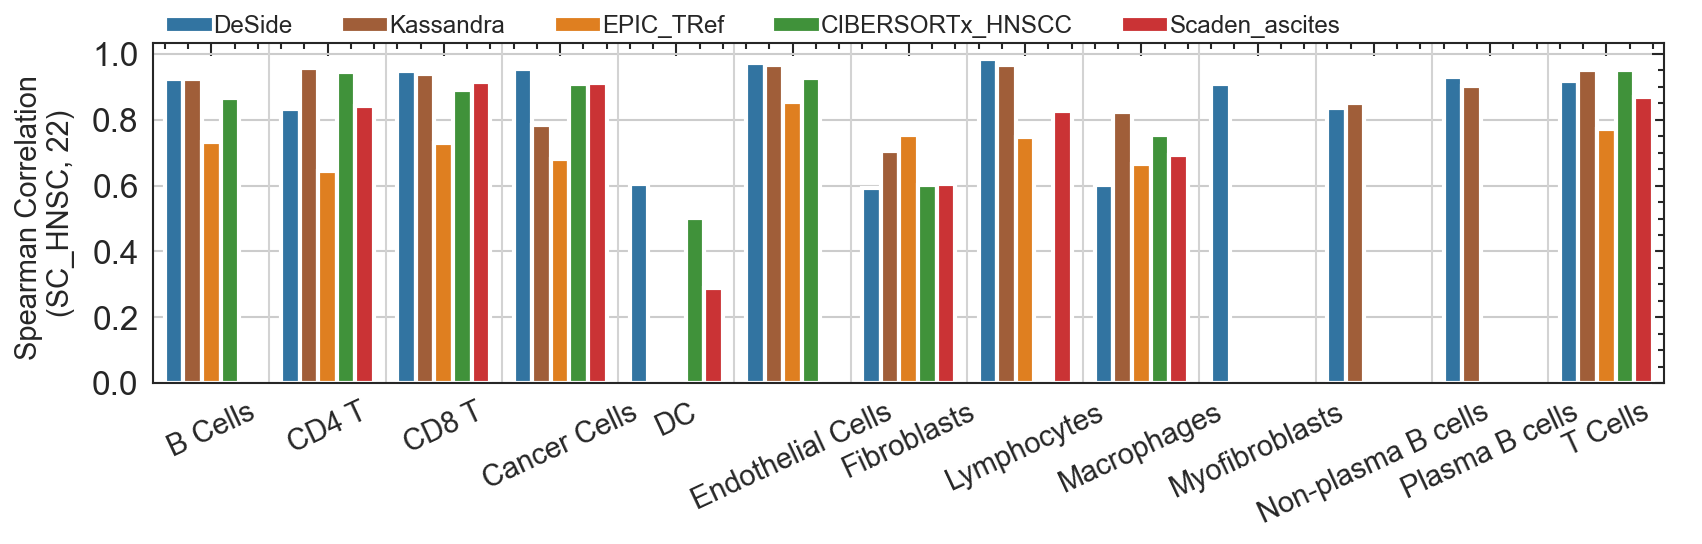

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 1.5))

hue_order_ds3 = [i for i in algos if i in algo_ct2ccc_df_hnscc['Algorithm'].unique()]
g1 = sns.barplot(algo_ct2ccc_df_hnscc, x="Cell type", y="corr", hue="Algorithm", 
                 palette=[algo2color[algo] for algo in hue_order_ds3], ax=ax1, hue_order=hue_order_ds3)
g1legend = g1.legend()
sns.move_legend(g1, 'upper left',  bbox_to_anchor=(0, 1.12), ncol=5, title=None, frameon=False, fontsize=5.8, borderpad=0, handletextpad=0)
ax1.grid(axis='y')
for _x in range(13):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
g1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(axis='x', labelrotation=25, labelsize=7)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis\n",
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("")
plt.ylabel('Spearman Correlation ' + '\n(' + f'SC_HNSC, 22' + ')', fontsize=7)

plt.savefig(os.path.join(fig_dir, 'cell_type_wise_corr_spearman_hnscc.svg'), dpi=300)

In [26]:
algo_ct2ccc_df_ds4['dataset'].unique()

array(['SC_HNSCC', 'SC_ovarian_cancer', 'SC_glioblastoma'], dtype=object)

In [27]:
algo_ct2ccc_df_ov = algo_ct2ccc_df_ds4.loc[(algo_ct2ccc_df_ds4['dataset'] == 'SC_ovarian_cancer') & (algo_ct2ccc_df_ds4['Cell type'] != 'T Cells'), :].copy()
print(algo_ct2ccc_df_ov.shape)
algo_ct2ccc_df_ov.head(2)

(26, 4)


,corr,Algorithm,Cell type,dataset
"(DeSide, B Cells, SC_ovarian_cancer)",0.528312,DeSide,B Cells,SC_ovarian_cancer
"(DeSide, Cancer Cells, SC_ovarian_cancer)",0.574861,DeSide,Cancer Cells,SC_ovarian_cancer


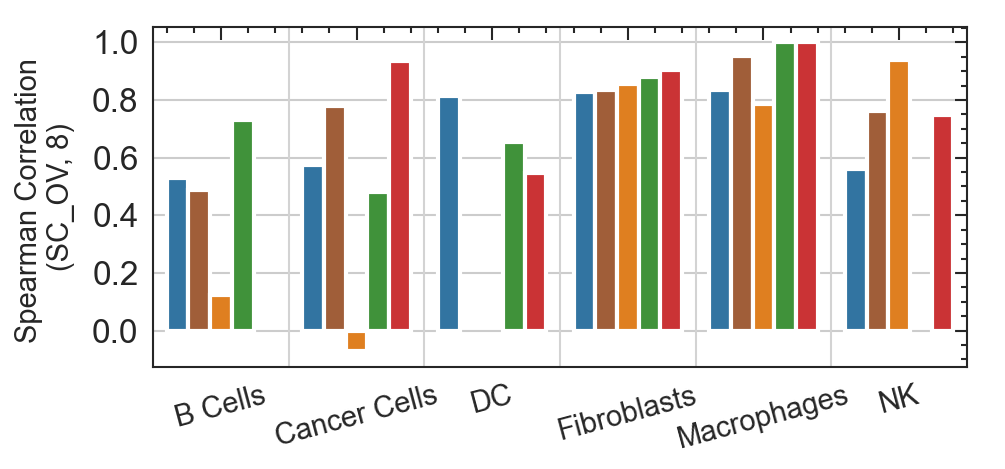

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(3.5, 1.5))

hue_order_ds3 = [i for i in algos if i in algo_ct2ccc_df_ov['Algorithm'].unique()]
g1 = sns.barplot(algo_ct2ccc_df_ov, x="Cell type", y="corr", hue="Algorithm", 
                 palette=[algo2color[algo] for algo in hue_order_ds3], ax=ax1, hue_order=hue_order_ds3)
# g1legend = g1.legend()
# sns.move_legend(g1, 'upper left',  bbox_to_anchor=(0, 1.12), ncol=5, title=None, frameon=False, fontsize=5.8, borderpad=0, handletextpad=0)
g1.legend([], [], frameon=False)
ax1.grid(axis='y')
for _x in range(6):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
g1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(axis='x', labelrotation=15, labelsize=7)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis\n",
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("")
plt.ylabel('Spearman Correlation ' + '\n(' + f'SC_OV, 8' + ')', fontsize=7)

plt.savefig(os.path.join(fig_dir, 'cell_type_wise_corr_spearman_ov.svg'), dpi=300)

In [29]:
algo_ct2ccc_df_gbm = algo_ct2ccc_df_ds4.loc[algo_ct2ccc_df_ds4['dataset'] == 'SC_glioblastoma', :].copy()
print(algo_ct2ccc_df_gbm.shape)
algo_ct2ccc_df_gbm.head(2)

(15, 4)


,corr,Algorithm,Cell type,dataset
"(DeSide, Cancer Cells, SC_glioblastoma)",0.75302,DeSide,Cancer Cells,SC_glioblastoma
"(DeSide, Macrophages, SC_glioblastoma)",0.96286,DeSide,Macrophages,SC_glioblastoma


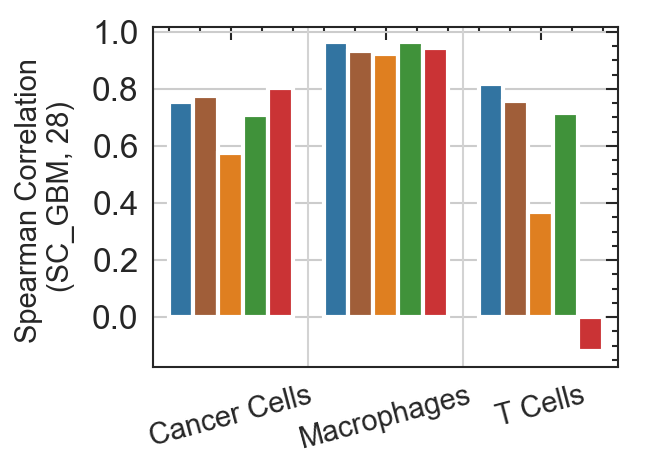

In [30]:
fig, ax1 = plt.subplots(1, 1, figsize=(2., 1.5))

hue_order_ds3 = [i for i in algos if i in algo_ct2ccc_df_gbm['Algorithm'].unique()]
g1 = sns.barplot(algo_ct2ccc_df_gbm, x="Cell type", y="corr", hue="Algorithm", 
                 palette=[algo2color[algo] for algo in hue_order_ds3], ax=ax1, hue_order=hue_order_ds3)
# g1legend = g1.legend()
# sns.move_legend(g1, 'upper left',  bbox_to_anchor=(0, 1.12), ncol=5, title=None, frameon=False, fontsize=5.8, borderpad=0, handletextpad=0)
g1.legend([], [], frameon=False)
ax1.grid(axis='y')
for _x in range(3):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
g1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(axis='x', labelrotation=15, labelsize=7)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis\n",
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("")
plt.ylabel('Spearman Correlation ' + '\n(' + f'SC_GBM, 28' + ')', fontsize=7)

plt.savefig(os.path.join(fig_dir, 'cell_type_wise_corr_spearman_gbm.svg'), dpi=300)

In [31]:
current_true.isna().values

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False]])

In [32]:
current_true.loc[:, ~current_true.isna().values[0]]

,T Cells
BT1160,0.000000
BT1187,0.063927
BT749,0.000000
BT771,0.000000
BT786,0.000000
BT830,0.000000
BT85,0.000000
BT920,0.000000
MGH100,0.000000
MGH101,0.000000


In [33]:
algo_ct2ccc = {}
for (algo, sample_id, datasets), group in cell_prop_pred_new.groupby(['algo', 'sample_id', 'datasets']):
    if sample_id in all_ground_truth.index:
        group['cell_proportion_pred'] = group['cell_proportion']
        # print(group)
        if algo not in ['DeSide', 'Scaden_ascites']:
            group['cell_proportion_pred'] = group['cell_proportion'] / 100
        group = group.set_index('cell_type')
        current_true = all_ground_truth.loc[[sample_id], :].copy()
        # print(current_true)
        current_true = current_true.loc[:, ~current_true.isna().values[0]].T.copy()
        # print(current_true)
        group_new = current_true.join(group, how='inner')
        # print(algo, sample_id, datasets, group_new.shape)
        # print(group_new)
        algo_ct2ccc[(algo, sample_id, datasets)] = get_corr_spearman(group_new[sample_id], group_new['cell_proportion_pred'])
algo_sample2corr = pd.DataFrame.from_dict(algo_ct2ccc, orient='index', columns=['corr'])
# algo_ct2ccc_df = algo_ct2ccc_df.reset_index()
algo_sample2corr['Algorithm'] = algo_sample2corr.index.map(lambda x: x[0].replace('_matrix_with_BC', ''))
algo_sample2corr['sample_id'] = algo_sample2corr.index.map(lambda x: x[1])
algo_sample2corr['datasets'] = algo_sample2corr.index.map(lambda x: x[2])
print_df(algo_sample2corr)

  >>  <<  
(290, 4)
                                       corr Algorithm sample_id  \
(DeSide, BT1160, SC_glioblastoma)  0.866025    DeSide    BT1160   
(DeSide, BT1187, SC_glioblastoma)  0.500000    DeSide    BT1187   

                                          datasets  
(DeSide, BT1160, SC_glioblastoma)  SC_glioblastoma  
(DeSide, BT1187, SC_glioblastoma)  SC_glioblastoma  


In [34]:
algo_ct2ccc = {}
for (algo, sample_id, datasets), group in cell_prop_pred_new.groupby(['algo', 'sample_id', 'datasets']):
    if sample_id in all_ground_truth.index:
        group['cell_proportion_pred'] = group['cell_proportion']
        # print(group)
        if algo not in ['DeSide', 'Scaden_ascites']:
            group['cell_proportion_pred'] = group['cell_proportion'] / 100
        group = group.set_index('cell_type')
        current_true = all_ground_truth.loc[[sample_id], :].copy()
        # print(current_true)
        current_true = current_true.loc[:, ~current_true.isna().values[0]].T.copy()
        # print(current_true)
        group_new = current_true.join(group, how='inner')
        # print(algo, sample_id, datasets, group_new.shape)
        # print(group_new)
        algo_ct2ccc[(algo, sample_id, datasets)] = get_ccc(group_new[sample_id], group_new['cell_proportion_pred'])
algo_sample2ccc = pd.DataFrame.from_dict(algo_ct2ccc, orient='index', columns=['ccc'])
# algo_ct2ccc_df = algo_ct2ccc_df.reset_index()
algo_sample2ccc['Algorithm'] = algo_sample2ccc.index.map(lambda x: x[0].replace('_matrix_with_BC', ''))
algo_sample2ccc['sample_id'] = algo_sample2ccc.index.map(lambda x: x[1])
algo_sample2ccc['datasets'] =  algo_sample2ccc.index.map(lambda x: x[2])
print_df(algo_sample2ccc)

  >>  <<  
(290, 4)
                                        ccc Algorithm sample_id  \
(DeSide, BT1160, SC_glioblastoma)  0.999890    DeSide    BT1160   
(DeSide, BT1187, SC_glioblastoma)  0.891916    DeSide    BT1187   

                                          datasets  
(DeSide, BT1160, SC_glioblastoma)  SC_glioblastoma  
(DeSide, BT1187, SC_glioblastoma)  SC_glioblastoma  


In [35]:
algo_sample2ccc['datasets'].unique()

array(['SC_glioblastoma', 'SC_ovarian_cancer', 'SC_HNSCC'], dtype=object)

### Plot (corr)

In [36]:
algo_name_mapping = {'HNSC_CIBERSORTX': 'CIBERSORTx_HNSCC'}
dataset_mapping = {'SC_glioblastoma': 'SC_GBM', 'SC_ovarian_cancer': 'SC_OV', 'SC_HNSCC': 'SC_HNSC'}
algo_sample2corr['Algorithm'] = algo_sample2corr['Algorithm'].map(lambda x: algo_name_mapping.get(x, x))
algo_sample2corr['datasets'] = algo_sample2corr['datasets'].map(lambda x: dataset_mapping.get(x, x))
algo_sample2corr['Algorithm'].unique(), algo_sample2corr['datasets'].unique()

(array(['DeSide', 'EPIC_TRef', 'CIBERSORTx_HNSCC', 'Kassandra',
        'Scaden_ascites'], dtype=object),
 array(['SC_GBM', 'SC_OV', 'SC_HNSC'], dtype=object))

In [37]:
selected_colors = [sns.color_palette("Paired")[i] for i in [1, 11, 7, 3, 5]]  #  [1, 0, 3, 2, 5, 4, 7, 11, 9]
sns.color_palette(selected_colors)

[(0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (1.0, 0.4980392156862745, 0.0),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745)]

In [38]:
# algos = ['DeSide', 'Kassandra', 'ABIS', 'fardeep_absolute', 
#          'EPIC_BRef', 'EPIC_TRef',
#          'HNSC_CIBERSORTX', 'LM22_CIBERSORTX', 
#          'quantiseq', 'quantiseq_tumor']
algos = ['DeSide', 'Kassandra', 'EPIC_TRef',
         'CIBERSORTx_HNSCC', 'Scaden_ascites']
algo2color = {algos[i]: selected_colors[i] for i in range(5)}

In [39]:
algo_sample2corr.head(2)

,corr,Algorithm,sample_id,datasets
"(DeSide, BT1160, SC_glioblastoma)",0.866025,DeSide,BT1160,SC_GBM
"(DeSide, BT1187, SC_glioblastoma)",0.500000,DeSide,BT1187,SC_GBM


In [40]:
algo_sample2corr.loc[:, ['corr', 'datasets', 'Algorithm']].groupby(['datasets', 'Algorithm']).mean()

corr
datasets Algorithm                 
SC_GBM   CIBERSORTx_HNSCC  0.866369
         DeSide            0.945146
         EPIC_TRef         0.652083
         Kassandra         0.919940
         Scaden_ascites    0.500939
SC_HNSC  CIBERSORTx_HNSCC  0.739969
         DeSide            0.854229
         EPIC_TRef         0.632137
         Kassandra         0.827246
         Scaden_ascites    0.799072
SC_OV    CIBERSORTx_HNSCC  0.500283
         DeSide            0.776999
         EPIC_TRef         0.539911
         Kassandra         0.562143
         Scaden_ascites    0.542219

In [41]:
algo_sample2corr.loc[:, ['corr', 'datasets', 'Algorithm']].groupby(['datasets', 'Algorithm']).std()

corr
datasets Algorithm                 
SC_GBM   CIBERSORTx_HNSCC  0.287604
         DeSide            0.134377
         EPIC_TRef         0.377322
         Kassandra         0.106087
         Scaden_ascites    0.489660
SC_HNSC  CIBERSORTx_HNSCC  0.167093
         DeSide            0.124314
         EPIC_TRef         0.275097
         Kassandra         0.171717
         Scaden_ascites    0.169677
SC_OV    CIBERSORTx_HNSCC  0.329906
         DeSide            0.224984
         EPIC_TRef         0.313638
         Kassandra         0.382366
         Scaden_ascites    0.342187

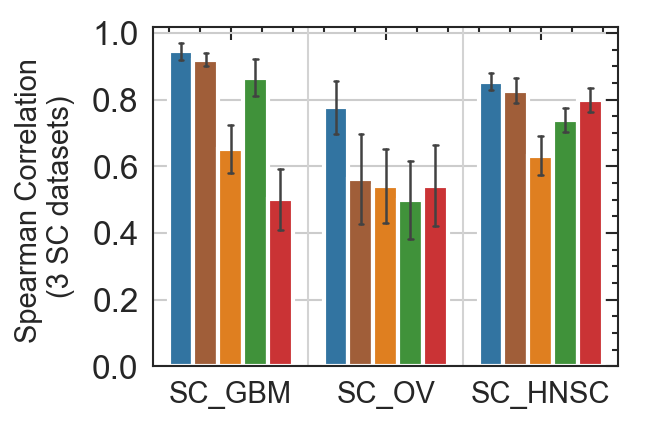

In [42]:
fig, ax1 = plt.subplots(1, 1, figsize=(2, 1.5))

hue_order_ds3 = [i for i in algos if i in algo_ct2ccc_df_ds4['Algorithm'].unique()]
g1 = sns.barplot(algo_sample2corr, x="datasets", y="corr", hue="Algorithm", errorbar='se', capsize=0.03, errwidth=0.6,
                 palette=[algo2color[algo] for algo in hue_order_ds3], ax=ax1, hue_order=hue_order_ds3)
# g1legend = g1.legend()
# sns.move_legend(g1, 'upper left',  bbox_to_anchor=(0, 1.12), ncol=5, title=None, frameon=False, fontsize=5.8, borderpad=0, handletextpad=0)
g1.legend([],[], frameon=False)
ax1.grid(axis='y')
for _x in range(3):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
g1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(axis='x', labelrotation=0, labelsize=7)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis\n",
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("")
plt.ylabel('Spearman Correlation ' + '\n(' + f'3 SC datasets' + ')', fontsize=7)

plt.savefig(os.path.join(fig_dir, '3ds_sample_wise_corr_spearman.svg'), dpi=300)

### Plot (ccc)

In [43]:
algo_name_mapping = {'HNSC_CIBERSORTX': 'CIBERSORTx_HNSCC'}
dataset_mapping = {'SC_glioblastoma': 'SC_GBM', 'SC_ovarian_cancer': 'SC_OV', 'SC_HNSCC': 'SC_HNSC'}
algo_sample2ccc['Algorithm'] = algo_sample2ccc['Algorithm'].map(lambda x: algo_name_mapping.get(x, x))
algo_sample2ccc['datasets'] =  algo_sample2ccc['datasets'].map(lambda x: dataset_mapping.get(x, x))
algo_sample2ccc['Algorithm'].unique(), algo_sample2ccc['datasets'].unique()

(array(['DeSide', 'EPIC_TRef', 'CIBERSORTx_HNSCC', 'Kassandra',
        'Scaden_ascites'], dtype=object),
 array(['SC_GBM', 'SC_OV', 'SC_HNSC'], dtype=object))

In [44]:
algo_sample2ccc.head(2)

,ccc,Algorithm,sample_id,datasets
"(DeSide, BT1160, SC_glioblastoma)",0.999890,DeSide,BT1160,SC_GBM
"(DeSide, BT1187, SC_glioblastoma)",0.891916,DeSide,BT1187,SC_GBM


In [45]:
algo_sample2ccc.loc[:, ['ccc', 'datasets', 'Algorithm']].groupby(['datasets', 'Algorithm']).mean()

ccc
datasets Algorithm                 
SC_GBM   CIBERSORTx_HNSCC  0.921202
         DeSide            0.992034
         EPIC_TRef         0.903405
         Kassandra         0.980876
         Scaden_ascites    0.193984
SC_HNSC  CIBERSORTx_HNSCC  0.435563
         DeSide            0.904496
         EPIC_TRef         0.728368
         Kassandra         0.735359
         Scaden_ascites    0.727830
SC_OV    CIBERSORTx_HNSCC  0.147812
         DeSide            0.894618
         EPIC_TRef         0.493373
         Kassandra         0.510041
         Scaden_ascites    0.868018

In [46]:
algo_sample2ccc.loc[:, ['ccc', 'datasets', 'Algorithm']].groupby(['datasets', 'Algorithm']).std()

ccc
datasets Algorithm                 
SC_GBM   CIBERSORTx_HNSCC  0.269291
         DeSide            0.022999
         EPIC_TRef         0.256057
         Kassandra         0.059856
         Scaden_ascites    0.235319
SC_HNSC  CIBERSORTx_HNSCC  0.422707
         DeSide            0.098904
         EPIC_TRef         0.271868
         Kassandra         0.294522
         Scaden_ascites    0.201213
SC_OV    CIBERSORTx_HNSCC  0.408696
         DeSide            0.061167
         EPIC_TRef         0.336676
         Kassandra         0.299866
         Scaden_ascites    0.201636

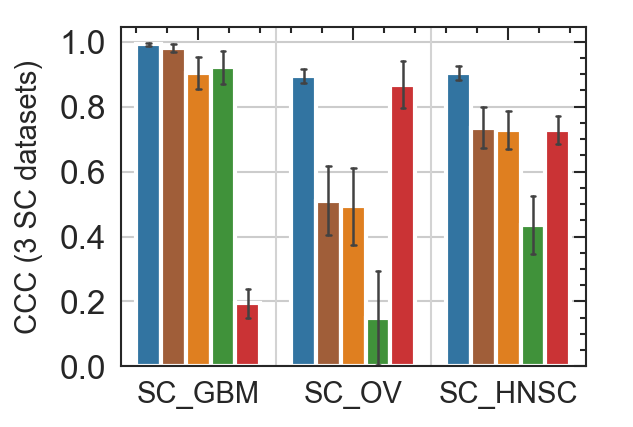

In [47]:
fig, ax1 = plt.subplots(1, 1, figsize=(2, 1.5))

hue_order_ds3 = [i for i in algos if i in algo_ct2ccc_df_ds4['Algorithm'].unique()]
g1 = sns.barplot(algo_sample2ccc, x="datasets", y="ccc", hue="Algorithm", errorbar='se', capsize=0.03, errwidth=0.6,
                 palette=[algo2color[algo] for algo in hue_order_ds3], ax=ax1, hue_order=hue_order_ds3)
# g1legend = g1.legend()
# sns.move_legend(g1, 'upper left',  bbox_to_anchor=(0, 1.12), ncol=5, title=None, frameon=False, fontsize=5.8, borderpad=0, handletextpad=0)
g1.legend([],[], frameon=False)
ax1.grid(axis='y')
for _x in range(3):
    ax1.axvline(_x - 0.5, color='lightgray', linewidth=0.5)
g1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.tick_params(axis='x', labelrotation=0, labelsize=7)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis\n",
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("")
plt.ylabel('CCC ' + '(' + f'3 SC datasets' + ')', fontsize=7)

plt.savefig(os.path.join(fig_dir, '3ds_sample_wise_cccc.svg'), dpi=300)